# Pet Segmentation

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
import imageio
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

# Data used

Will be using The Oxford-IIIT Pet Dataset (https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset). This dataset is both farily lightweight and sufficient for the task in hand.

In [2]:
def show_images(num, image_files, mask_files):
    fig, axs = plt.subplots(num, 2, figsize=(18, 12))
    for i in range(num):
        image = Image.open(image_files[i])
        mask = Image.open(mask_files[i])
        mask_np = np.array(mask)
        mask_np[mask_np == 3] = 1
        mask = Image.fromarray(np.uint8(mask_np))
        axs[i][0].imshow(image)
        axs[i][0].set_title(f"Image {i}")
        axs[i][1].imshow(mask)
        axs[i][1].set_title(f"Mask {i}")

7390 7390


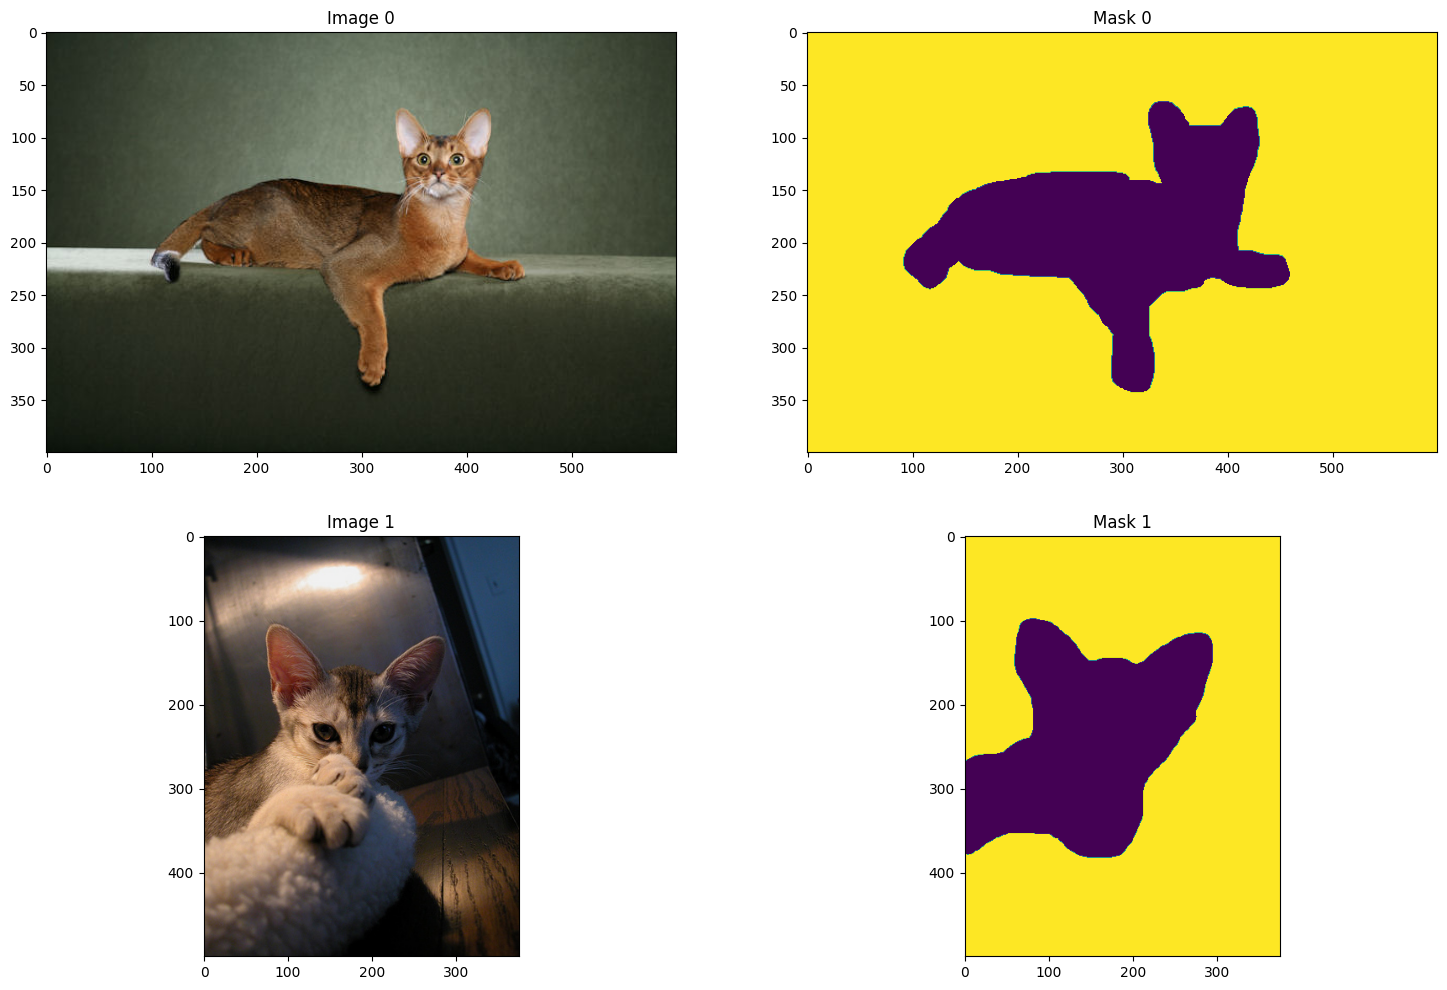

In [3]:
# Loading the dataset
image_path = "./data/pets/images/images/"
mask_path = "./data/pets/annotations/annotations/trimaps/"

image_files = [image_path + file for file in os.listdir(image_path) if file[-3:] == "jpg"]
mask_files = [mask_path + file for file in os.listdir(mask_path) if file[0] != '.' and file[-3:] == "png"]

image_files.sort()
mask_files.sort()

print(len(image_files), len(mask_files))
show_images(2, image_files, mask_files)

In [4]:
import random

def add_gaussian_noise(image, mean = 0, var = 0.1):
    row, col, ch= image.shape
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy

def add_sp_noise(image, p = 0.05):
    noisy = np.zeros(image.shape,np.uint8)
    thres = 1 - p 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < p:
                noisy[i][j] = 0
            elif rdn > thres:
                noisy[i][j] = 255
            else:
                noisy[i][j] = image[i][j]
    return noisy

def add_poisson_noise(image):
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy

def add_noise(image): # modifying images to expand dataset
    rdn = random.random()
    if rdn < 0.33:
        noisy = add_gaussian_noise(image)
    elif rdn < 0.67:
        noisy = add_sp_noise(image)
    else:
        noisy = add_poisson_noise(image)
        
    return noisy

In [5]:
def preprocessing(images, masks, input_shape, output_shape):
    input_height, input_width, input_channels = input_shape
    output_height, output_width, output_channels = output_shape
    x = np.zeros((len(images),input_height, input_width, input_channels))
    y = np.zeros((len(masks),output_height, output_width, output_channels))
    
    for image_name, mask_name in zip(images,masks):
        image = Image.open(image_name).convert('RGB')
        mask = Image.open(mask_name)
        mask_np = np.array(mask)
        mask_np[mask_np == 3] = 1
        mask = Image.fromarray(np.uint8(mask_np))
        
        image = image.resize((input_height,input_width))
        image = np.reshape(image,input_shape)
        image = image / 256
        
        mask = mask.resize((output_height,output_width))
        mask = np.reshape(mask,output_shape)
        mask = mask - 1
        
        ind = images.index(image_name)
        x[ind] = image
        y[ind] = mask
        
    return x, y

# Defining the model

In [6]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    conv = Conv2D(n_filters, 
                  3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,  
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
  
    conv = BatchNormalization()(conv, training=False)    
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
    skip_connection = conv    
    return next_layer, skip_connection

In [7]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same'
                    )(prev_layer_input)    
    merge = concatenate([up, skip_layer_input], axis=3)    
    conv = Conv2D(n_filters, 
                 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3, 
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [8]:
def make_model(input_size=(128, 128, 3), n_filters=32, n_classes=2):
    inputs = Input(input_size)
    
    # encoder part of the model 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)
    
    # decoder part of the model
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

X Shape: (7390, 128, 128, 3)
Y shape: (7390, 128, 128, 1)
[0. 1.]


Text(0.5, 1.0, 'Processed Masked Image ')

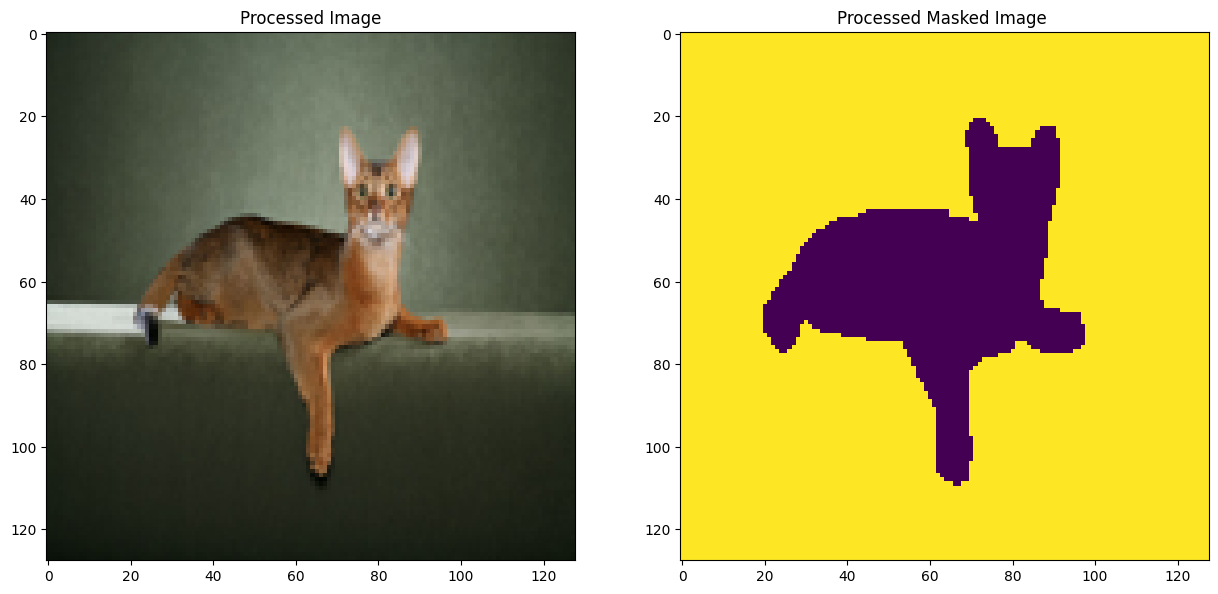

In [9]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function
X, y = preprocessing(image_files, mask_files, target_shape_img, target_shape_mask)

# QC the shape of output and classes in output dataset 
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 2 classes : background, pet
print(np.unique(y))

# Visualize the output
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [11]:
model = make_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

 conv2d_15 (Conv2D)             (None, 64, 64, 64)   36928       ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 128, 128, 32  18464      ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 64  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'batch_normalization[0][0]']    
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 32  18464       ['concatenate_3[0][0]']          
                                )                                                                 
          

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
185/185 [==============================] - 53s 199ms/step - loss: 0.5909 - accuracy: 0.6731 - val_loss: 0.4686 - val_accuracy: 0.7887
Epoch 2/10
185/185 [==============================] - 31s 167ms/step - loss: 0.4309 - accuracy: 0.8055 - val_loss: 0.3974 - val_accuracy: 0.8256
Epoch 3/10
185/185 [==============================] - 31s 168ms/step - loss: 0.3501 - accuracy: 0.8485 - val_loss: 0.3150 - val_accuracy: 0.8689
Epoch 4/10
185/185 [==============================] - 31s 168ms/step - loss: 0.2912 - accuracy: 0.8780 - val_loss: 0.2841 - val_accuracy: 0.8797
Epoch 5/10
185/185 [==============================] - 31s 168ms/step - loss: 0.2636 - accuracy: 0.8910 - val_loss: 0.2617 - val_accuracy: 0.8932
Epoch 6/10
185/185 [==============================] - 31s 169ms/step - loss: 0.2416 - accuracy: 0.9020 - val_loss: 0.2446 - val_accuracy: 0.8982
Epoch 7/10
185/185 [==============================] - 31s 169ms/step - loss: 0.2188 - accuracy: 0.9116 - val_loss: 0.2422 - val_ac

In [14]:
model.save("testo.h5")

# Evaluation

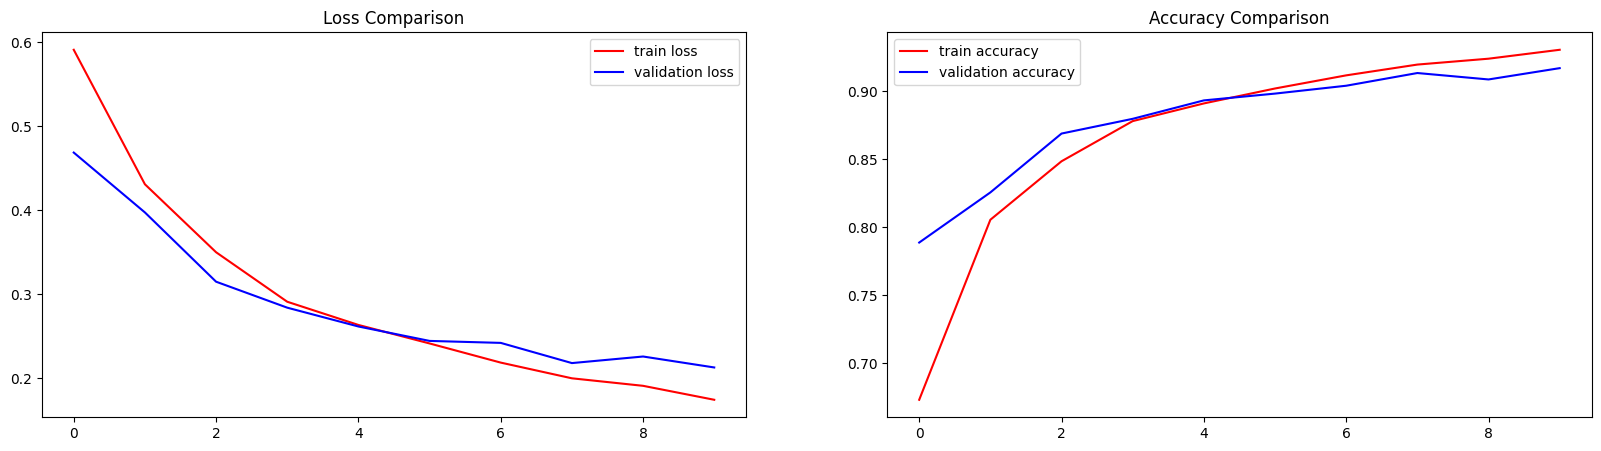

In [15]:
# graphing accuracy and loss
def graph_acc_loss(history):
    fig, axis = plt.subplots(1, 2, figsize=(20, 5))
    axis[0].plot(history.history["loss"], color='r', label = 'train loss')
    axis[0].plot(history.history["val_loss"], color='b', label = 'validation loss')
    axis[0].set_title('Loss Comparison')
    axis[0].legend()
    axis[1].plot(history.history["accuracy"], color='r', label = 'train accuracy')
    axis[1].plot(history.history["val_accuracy"], color='b', label = 'validation accuracy')
    axis[1].set_title('Accuracy Comparison')
    axis[1].legend()
    
graph_acc_loss(history)

1/1 [==============================] - 1s 732ms/step


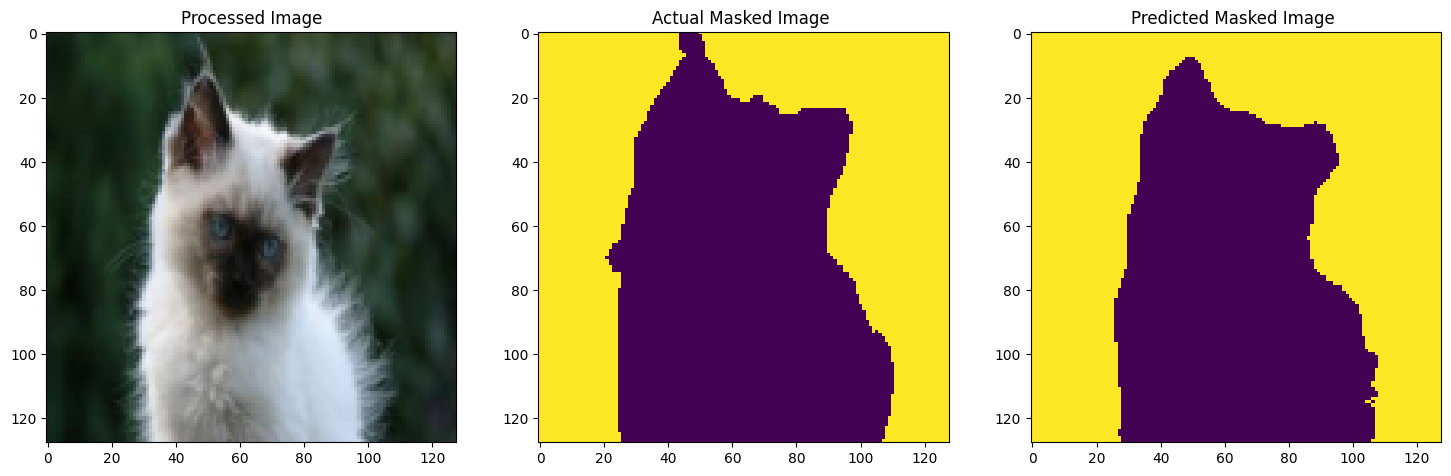

In [16]:
# predictions using validation dataset
def predict_plot(ind, img = []):
    from_dataset = False
    if len(img) == 0:
        img = X_valid[ind]
        from_dataset = True
    img = img[np.newaxis, ...]
    pred = model.predict(img)
    pred_mask = tf.argmax(pred[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    if from_dataset:
        fig, axis = plt.subplots(1,3,figsize=(18,6))
        axis[0].imshow(X_valid[ind])
        axis[0].set_title('Processed Image')
        axis[1].imshow(y_valid[ind,:,:,0])
        axis[1].set_title('Actual Masked Image ')
        axis[2].imshow(pred_mask[:,:,0])
        axis[2].set_title('Predicted Masked Image ')
        
    else:
        img = np.squeeze(img)
        fig, axis = plt.subplots(1,2,figsize=(18,9))
        axis[0].imshow(img)
        axis[0].set_title('Processed Image')
        axis[1].imshow(pred_mask[:,:,0])
        axis[1].set_title('Predicted Masked Image ')
    
predict_plot(90)

# Testing on data outside of dataset

In [17]:
images = ["./data/mytest1.jpg", "./data/mytest2.jpg"]

def prepare_images(images, input_shape):
    input_height, input_width, input_channels = input_shape
    x = np.zeros((len(images),input_height, input_width, input_channels))
    
    for image_name in images:
        image = Image.open(image_name).convert('RGB')
        image = image.resize((input_height,input_width))
        image = np.reshape(image,input_shape)
        image = image / 256
        
        ind = images.index(image_name)
        x[ind] = image
    
    return x

prepared_images = prepare_images(images, target_shape_img)

1/1 [==============================] - 0s 24ms/step


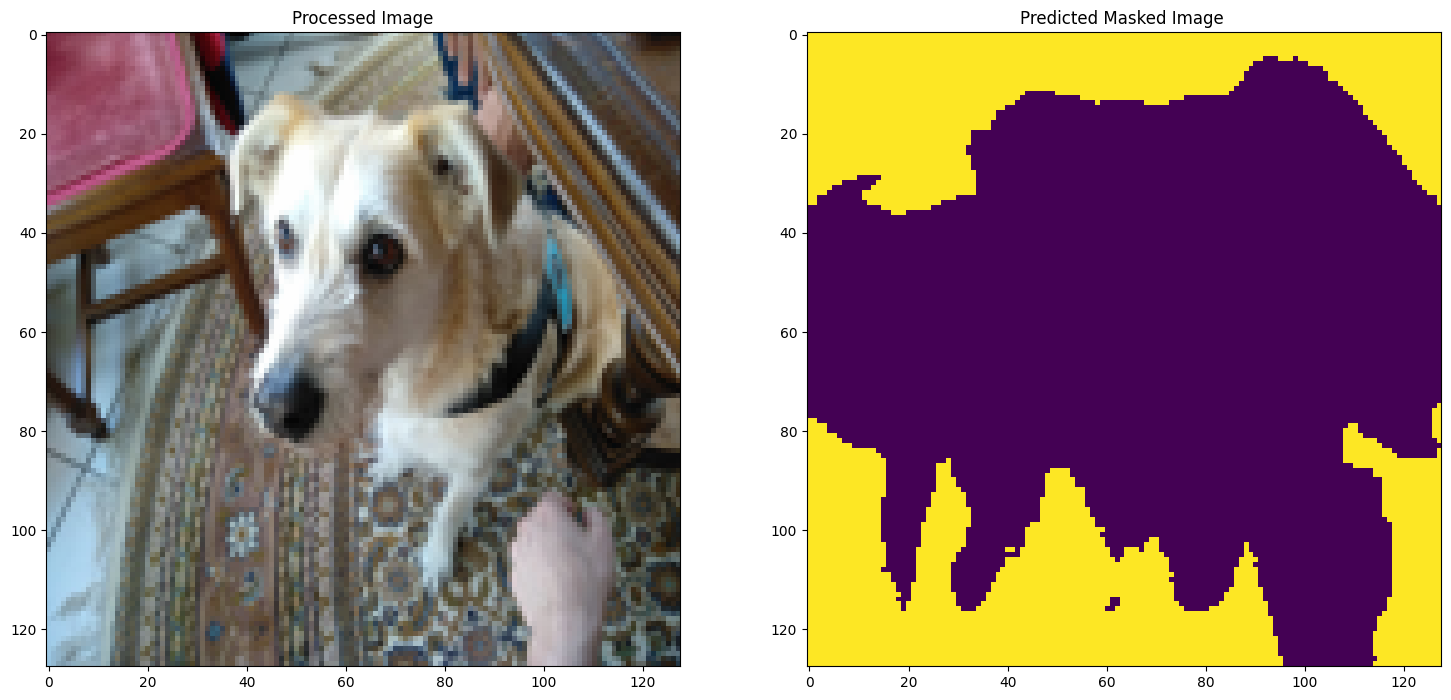

In [18]:
predict_plot(0, prepared_images[0])

1/1 [==============================] - 0s 23ms/step


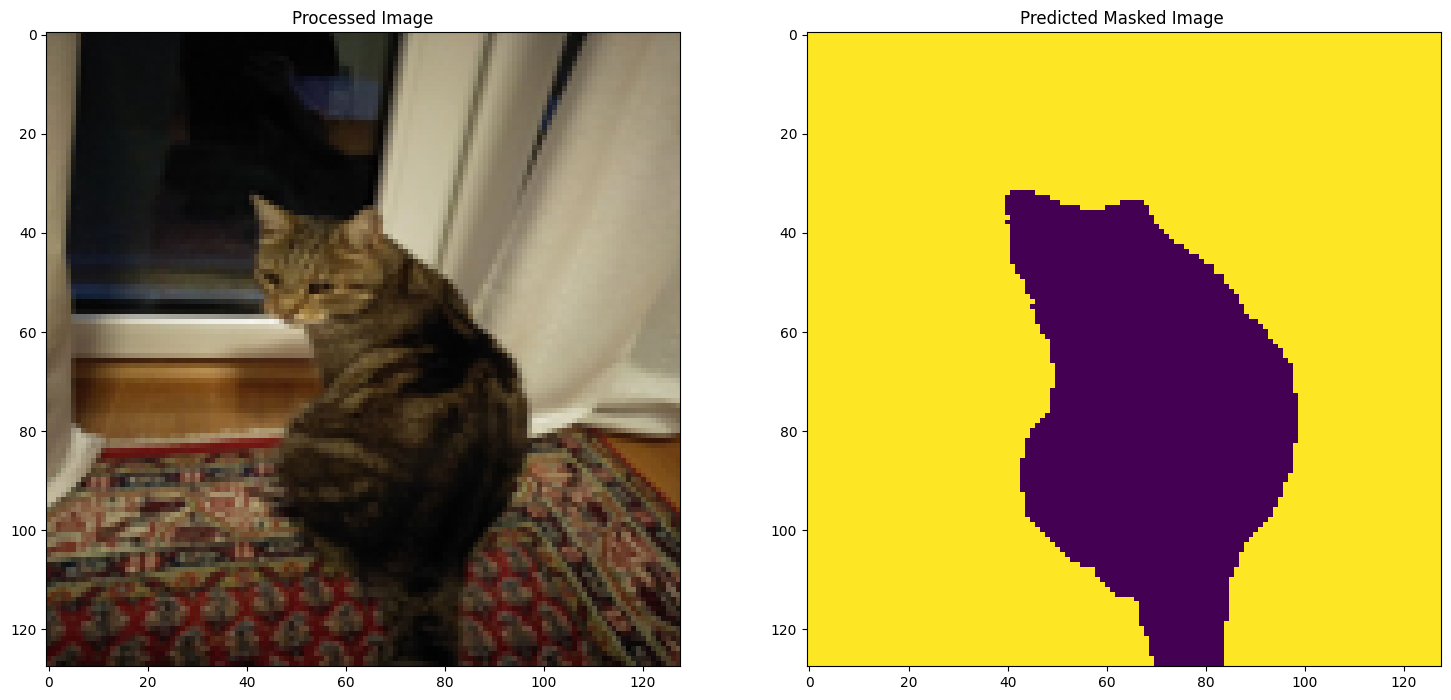

In [19]:
predict_plot(1, prepared_images[1])